In [12]:
import torch
from torch import nn
from torchsummary import summary

# Выполнять вычисления лучше на gpu
tensor_device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

In [13]:
# Готовим тренировочные данные.
# Вход и выход - вектора.
data_train = [
		{ "in": [0, 0], "out": [0] },
		{ "in": [0, 1], "out": [1] },
		{ "in": [1, 0], "out": [1] },
		{ "in": [1, 1], "out": [0] },
]

# Превращаем в два листа - вопрос и ответ
tensor_train_x = list(map(lambda item: item["in"], data_train))
tensor_train_y = list(map(lambda item: item["out"], data_train))

# Преобразуем в тензор с float32 с помощью торча
tensor_train_x = torch.tensor(tensor_train_x).to(torch.float32).to(tensor_device)
tensor_train_y = torch.tensor(tensor_train_y).to(torch.float32).to(tensor_device)

In [14]:
# Проверяем правильность данных
print ("Вход:")
print (tensor_train_x)
print ("Размерность вектора:", tensor_train_x.shape)
print ("")
print ("Ответы:")
print (tensor_train_y)
print ("размерность вектора:", tensor_train_y.shape)
# Вход - 4 2ух-мерных вектора; Выход - 4 1но-мерных вектора

Вход:
tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]], device='cuda:0')
Размерность вектора: torch.Size([4, 2])

Ответы:
tensor([[0.],
        [1.],
        [1.],
        [0.]], device='cuda:0')
размерность вектора: torch.Size([4, 1])


In [21]:
input_shape = 2 # Размерность входа и выхода как описано выше.
output_shape = 1

# Скрытый слой из 16 нейронов с функцией активации Relu.
# All neural networks are implemented with nn.Module. If the layers are sequentially used (self.layer3(self.layer2(self.layer1(x))), you can leverage nn.Sequential to not have to define the forward function of the model.
model = nn.Sequential(
	nn.Linear(input_shape, 16),
	nn.ReLU(),
	nn.Linear(16, output_shape)
)

model.cuda() # Иначе выдает ошибку, что тензоры на разных девайсах, т.к. model.to - появляется только в ячейке ниже

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=1, bias=True)
)

In [22]:
#Оптимизация модели
# Оптимизатор Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

# mean squared error
loss = nn.MSELoss()

# Batch size
batch_size = 2

# Epochs
epochs = 1000

In [23]:
summary(model, (input_shape,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]              48
              ReLU-2                   [-1, 16]               0
            Linear-3                    [-1, 1]              17
Total params: 65
Trainable params: 65
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [24]:
# Обучение с помощью fit

history = []

# Переместим модель на устройство
model = model.to(tensor_device)

for i in range(epochs):
	
	# Вычислим результат модели
	model_res = model(tensor_train_x)
	
	# Найдем значение ошибки между ответом модели и правильными ответами
	loss_value = loss(model_res, tensor_train_y)
	
	# Добавим значение ошибки в историю, для дальнейшего отображения на графике
	loss_value_item = loss_value.item()
	history.append(loss_value_item)
	
	# Вычислим градиент
	optimizer.zero_grad()
	loss_value.backward()
	
	# Оптимизируем
	optimizer.step()
	
	# Остановим обучение, если ошибка меньше чем 0.01
	if loss_value_item < 0.01:
		break
	
	# Отладочная информация
	if i % 10 == 0:
		print (f"{i+1},\t loss: {loss_value_item}")
	
	# Очистим кэш CUDA
	if torch.cuda.is_available():
		torch.cuda.empty_cache()

1,	 loss: 0.4590420126914978
11,	 loss: 0.4068171977996826
21,	 loss: 0.3650370240211487
31,	 loss: 0.331632524728775
41,	 loss: 0.3053731918334961
51,	 loss: 0.2849001884460449
61,	 loss: 0.26867908239364624
71,	 loss: 0.25579679012298584
81,	 loss: 0.24487265944480896
91,	 loss: 0.2347886860370636
101,	 loss: 0.22528240084648132
111,	 loss: 0.21604067087173462
121,	 loss: 0.2070227563381195
131,	 loss: 0.19804655015468597
141,	 loss: 0.18933376669883728
151,	 loss: 0.18109750747680664
161,	 loss: 0.1728576421737671
171,	 loss: 0.16464897990226746
181,	 loss: 0.15647169947624207
191,	 loss: 0.14867302775382996
201,	 loss: 0.1409216672182083
211,	 loss: 0.13315922021865845
221,	 loss: 0.12549394369125366
231,	 loss: 0.11792219430208206
241,	 loss: 0.11036509275436401
251,	 loss: 0.1029871255159378
261,	 loss: 0.09566468000411987
271,	 loss: 0.08851803839206696
281,	 loss: 0.08150225132703781
291,	 loss: 0.07469648122787476
301,	 loss: 0.06809379160404205
311,	 loss: 0.06169195473194122

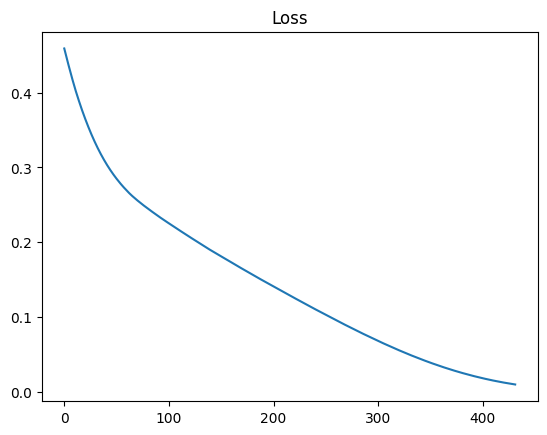

In [25]:
# Выводим график
import matplotlib.pyplot as plt

plt.plot(history)
plt.title('Loss')
plt.savefig('xor_torch.png')
plt.show()

# Видно что ошибка стремиться к нулю

In [26]:
# Тест для нейронной сети
control_x = [
	[0, 0],
	[0, 1],
	[1, 0],
	[1, 1],
]

control_x = torch.tensor(control_x).to(torch.float32).to(tensor_device)

print ("Shape:", control_x.shape)

answer = model( control_x )

for i in range(len(answer)):
	print(control_x[i].tolist(), "->", answer[i].round().tolist())

Shape: torch.Size([4, 2])
[0.0, 0.0] -> [0.0]
[0.0, 1.0] -> [1.0]
[1.0, 0.0] -> [1.0]
[1.0, 1.0] -> [0.0]
